# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [4]:
# Import Python packages 
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [5]:
# checking your current working directory
print(os.getcwd())

# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    print(file_path_list[1])

/home/workspace
/home/workspace/event_data/2018-11-04-events.csv


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [6]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 
            
# uncomment the code below if you would like to get total number of rows 
print(len(full_data_rows_list))
# uncomment the code below if you would like to check to see what the list of event data rows will look like
print(full_data_rows_list[0])



8056
['Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', 'Logged In', 'Mohammad', 'M', '0', 'Rodriguez', '277.15873', 'paid', 'Sacramento--Roseville--Arden-Arcade, CA', 'PUT', 'NextSong', '1.54051E+12', '961', 'Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)', '200', '1.54328E+12', '88']


In [7]:
# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


In [8]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


# Part II. Complete the Apache Cassandra coding portion of your project. 

## Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

<img src="images/image_event_datafile_new.jpg">

## Begin writing your Apache Cassandra code in the cells below

#### Creating a Cluster

In [9]:
from cassandra.cluster import Cluster
try: 
    cluster = Cluster(['127.0.0.1']) #If you have a locally installed Apache Cassandra instance
    session = cluster.connect()
except Exception as e:
    print(e)

#### Create Keyspace

In [10]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Set Keyspace

In [11]:
try:
    session.set_keyspace('udacity')
except Exception as e:
    print(e)

### Now we need to create tables to run the following queries. Remember, with Apache Cassandra you model the database tables on the queries you want to run.

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'




# Analysis

In [60]:
file = 'event_datafile_new.csv'
df = pd.read_csv(file)
df.head()

,artist,firstName,gender,itemInSession,lastName,length,level,location,sessionId,song,userId
0,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Mohammad,M,0,Rodriguez,277.15873,paid,"Sacramento--Roseville--Arden-Arcade, CA",961,Horn Concerto No. 4 in E flat K495: II. Romanc...,88
1,Jimi Hendrix,Mohammad,M,1,Rodriguez,239.82975,paid,"Sacramento--Roseville--Arden-Arcade, CA",961,Woodstock Inprovisation,88
2,Building 429,Mohammad,M,2,Rodriguez,300.61669,paid,"Sacramento--Roseville--Arden-Arcade, CA",961,Majesty (LP Version),88
3,The B-52's,Gianna,F,0,Jones,321.54077,free,"New York-Newark-Jersey City, NY-NJ-PA",107,Love Shack,38
4,Die Mooskirchner,Gianna,F,1,Jones,169.29914,free,"New York-Newark-Jersey City, NY-NJ-PA",107,Frisch und g'sund,38


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc52d49d4e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc52d4a25c0>]], dtype=object)

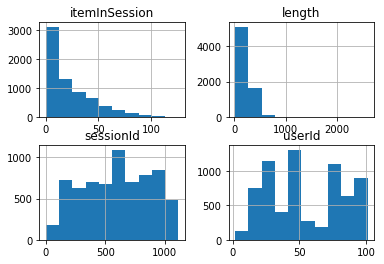

In [61]:
display(df.hist())

# Queries


#### Query 1

Give me the artist, song title and song's length in the music app history that was heard during sessionId = 338, and itemInSession = 4

Here, We need to create a primary key on sessionid and iteminsession, sessionid is the partitioning key which will partition the date in way so that all the records for same session id will be stored in same partition.


In [15]:
## Create table
query = "CREATE TABLE IF NOT EXISTS music_by_sessionId_and_itemInSession"
query = query + "(sessionId int, itemInSession int, artistName text, songTitle text, songLength double, PRIMARY KEY (sessionId, itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)            

In [16]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
    
        ## create insert statement
        query = "INSERT INTO music_by_sessionId_and_itemInSession (sessionId, itemInSession, artistName, songTitle, songLength )"
        query = query + "VALUES (%s, %s, %s, %s, %s)"
        
        ## for row insert specific columns into Cassandra table
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5]) ))

#### Do a SELECT to verify that the data have been inserted into each table

In [18]:
query = "select artistname, songtitle, songlength from music_by_sessionId_and_itemInSession WHERE sessionId = 338 and itemInSession = 4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

## artistName, songTitle, songLength
for row in rows:
    print (row.artistname, row.songtitle, row.songlength)

Faithless Music Matters (Mark Knight Dub) 495.3073


#### Query 2

Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182


Here, We need to create a primary key on userId and sessionid, userid is the partitioning key which will partition the data in way so that all the records for same user id will be stored in same partition. Additionally, we use itemInSession as the clustering id to sort the order of the return results.


In [66]:
df.head(1)

,artist,firstName,gender,itemInSession,lastName,length,level,location,sessionId,song,userId
0,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Mohammad,M,0,Rodriguez,277.15873,paid,"Sacramento--Roseville--Arden-Arcade, CA",961,Horn Concerto No. 4 in E flat K495: II. Romanc...,88


In [19]:
## create table 
query = "CREATE TABLE IF NOT EXISTS music_by_sessionId_and_userId"
query = query + "(userId int,sessionid int, itemInSession int, artist_name text, song_name text, user_first_name text, user_second_name text, PRIMARY KEY ((userId, sessionid), itemInSession) )"
try:
    session.execute(query)
except Exception as e:
    print(e)
                    

In [20]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        
        ## create insert statement
        query = "INSERT INTO music_by_sessionId_and_userId (userId, sessionid, itemInSession, artist_name, song_name, user_first_name, user_second_name)"
        query = query + "VALUES (%s, %s, %s, %s, %s, %s, %s)"
        
        ## for row insert specific columns into Cassandra table
        session.execute(query, ( int(line[10]), int(line[8]), int(line[3]), line[0], line[9], line[1], line[4] ))

In [22]:
query = "select iteminsession, artist_name, song_name, user_first_name, user_second_name from music_by_sessionId_and_userId WHERE userid = 10 and sessionid = 182"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.artist_name, row.song_name, row.iteminsession, row.user_first_name, row.user_second_name)

Down To The Bone Keep On Keepin' On 0 Sylvie Cruz
Three Drives Greece 2000 1 Sylvie Cruz
Sebastien Tellier Kilometer 2 Sylvie Cruz
Lonnie Gordon Catch You Baby (Steve Pitron & Max Sanna Radio Edit) 3 Sylvie Cruz


#### Query 3

Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'


Here, We need to create a primary key on song, song is the partitioning key which will partition the data in way so that all the records for same song will be stored in same partition. Additionally, we use userid as the clustering id to sort the order of the return results.

In [70]:
df.head(1)

,artist,firstName,gender,itemInSession,lastName,length,level,location,sessionId,song,userId
0,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Mohammad,M,0,Rodriguez,277.15873,paid,"Sacramento--Roseville--Arden-Arcade, CA",961,Horn Concerto No. 4 in E flat K495: II. Romanc...,88


In [23]:
query = "CREATE TABLE IF NOT EXISTS music_by_song"
query = query + "(song text, userId int, user_first_name text, user_second_name text,  PRIMARY KEY ((song), userId))"
try:
    session.execute(query)
except Exception as e:
    print(e)                    

In [24]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        
        ## create insert statement
        query = "INSERT INTO music_by_song ( song, userId, user_first_name, user_second_name)"
        query = query + "VALUES (%s, %s, %s, %s)"
        
        ## for row insert specific columns into Cassandra table
        session.execute(query, (line[9], int(line[10]), line[1], line[4]))

In [25]:
query = "select user_first_name, user_second_name from music_by_song WHERE song='All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.user_first_name, row.user_second_name)

Jacqueline Lynch
Tegan Levine
Sara Johnson


### Drop the tables before closing out the sessions

#### Drop the table before closing out the sessions

In [26]:
query = "drop table music_by_sessionId_and_itemInSession"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

query = "drop table music_by_sessionId_and_userId"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
query = "drop table music_by_song"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

### Close the session and cluster connection¶

In [27]:
session.shutdown()
cluster.shutdown()